In [1]:
from lime_exlpain import Seq2SeqLimeExplainer
from model_layer.model_hub import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

## 0 Create Explainer

In [2]:
future_index = 'IC'
encoder_class = EncoderGRU
decoder_class = AttnDecoderGRU
lime_explainer = Seq2SeqLimeExplainer(future_index=future_index, encoder_class=encoder_class,
                                 decoder_class=decoder_class)

W0410 22:20:24.357029 8580 warnings.py:109] D:\Anaconda\envs\nni\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17088626278010194 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



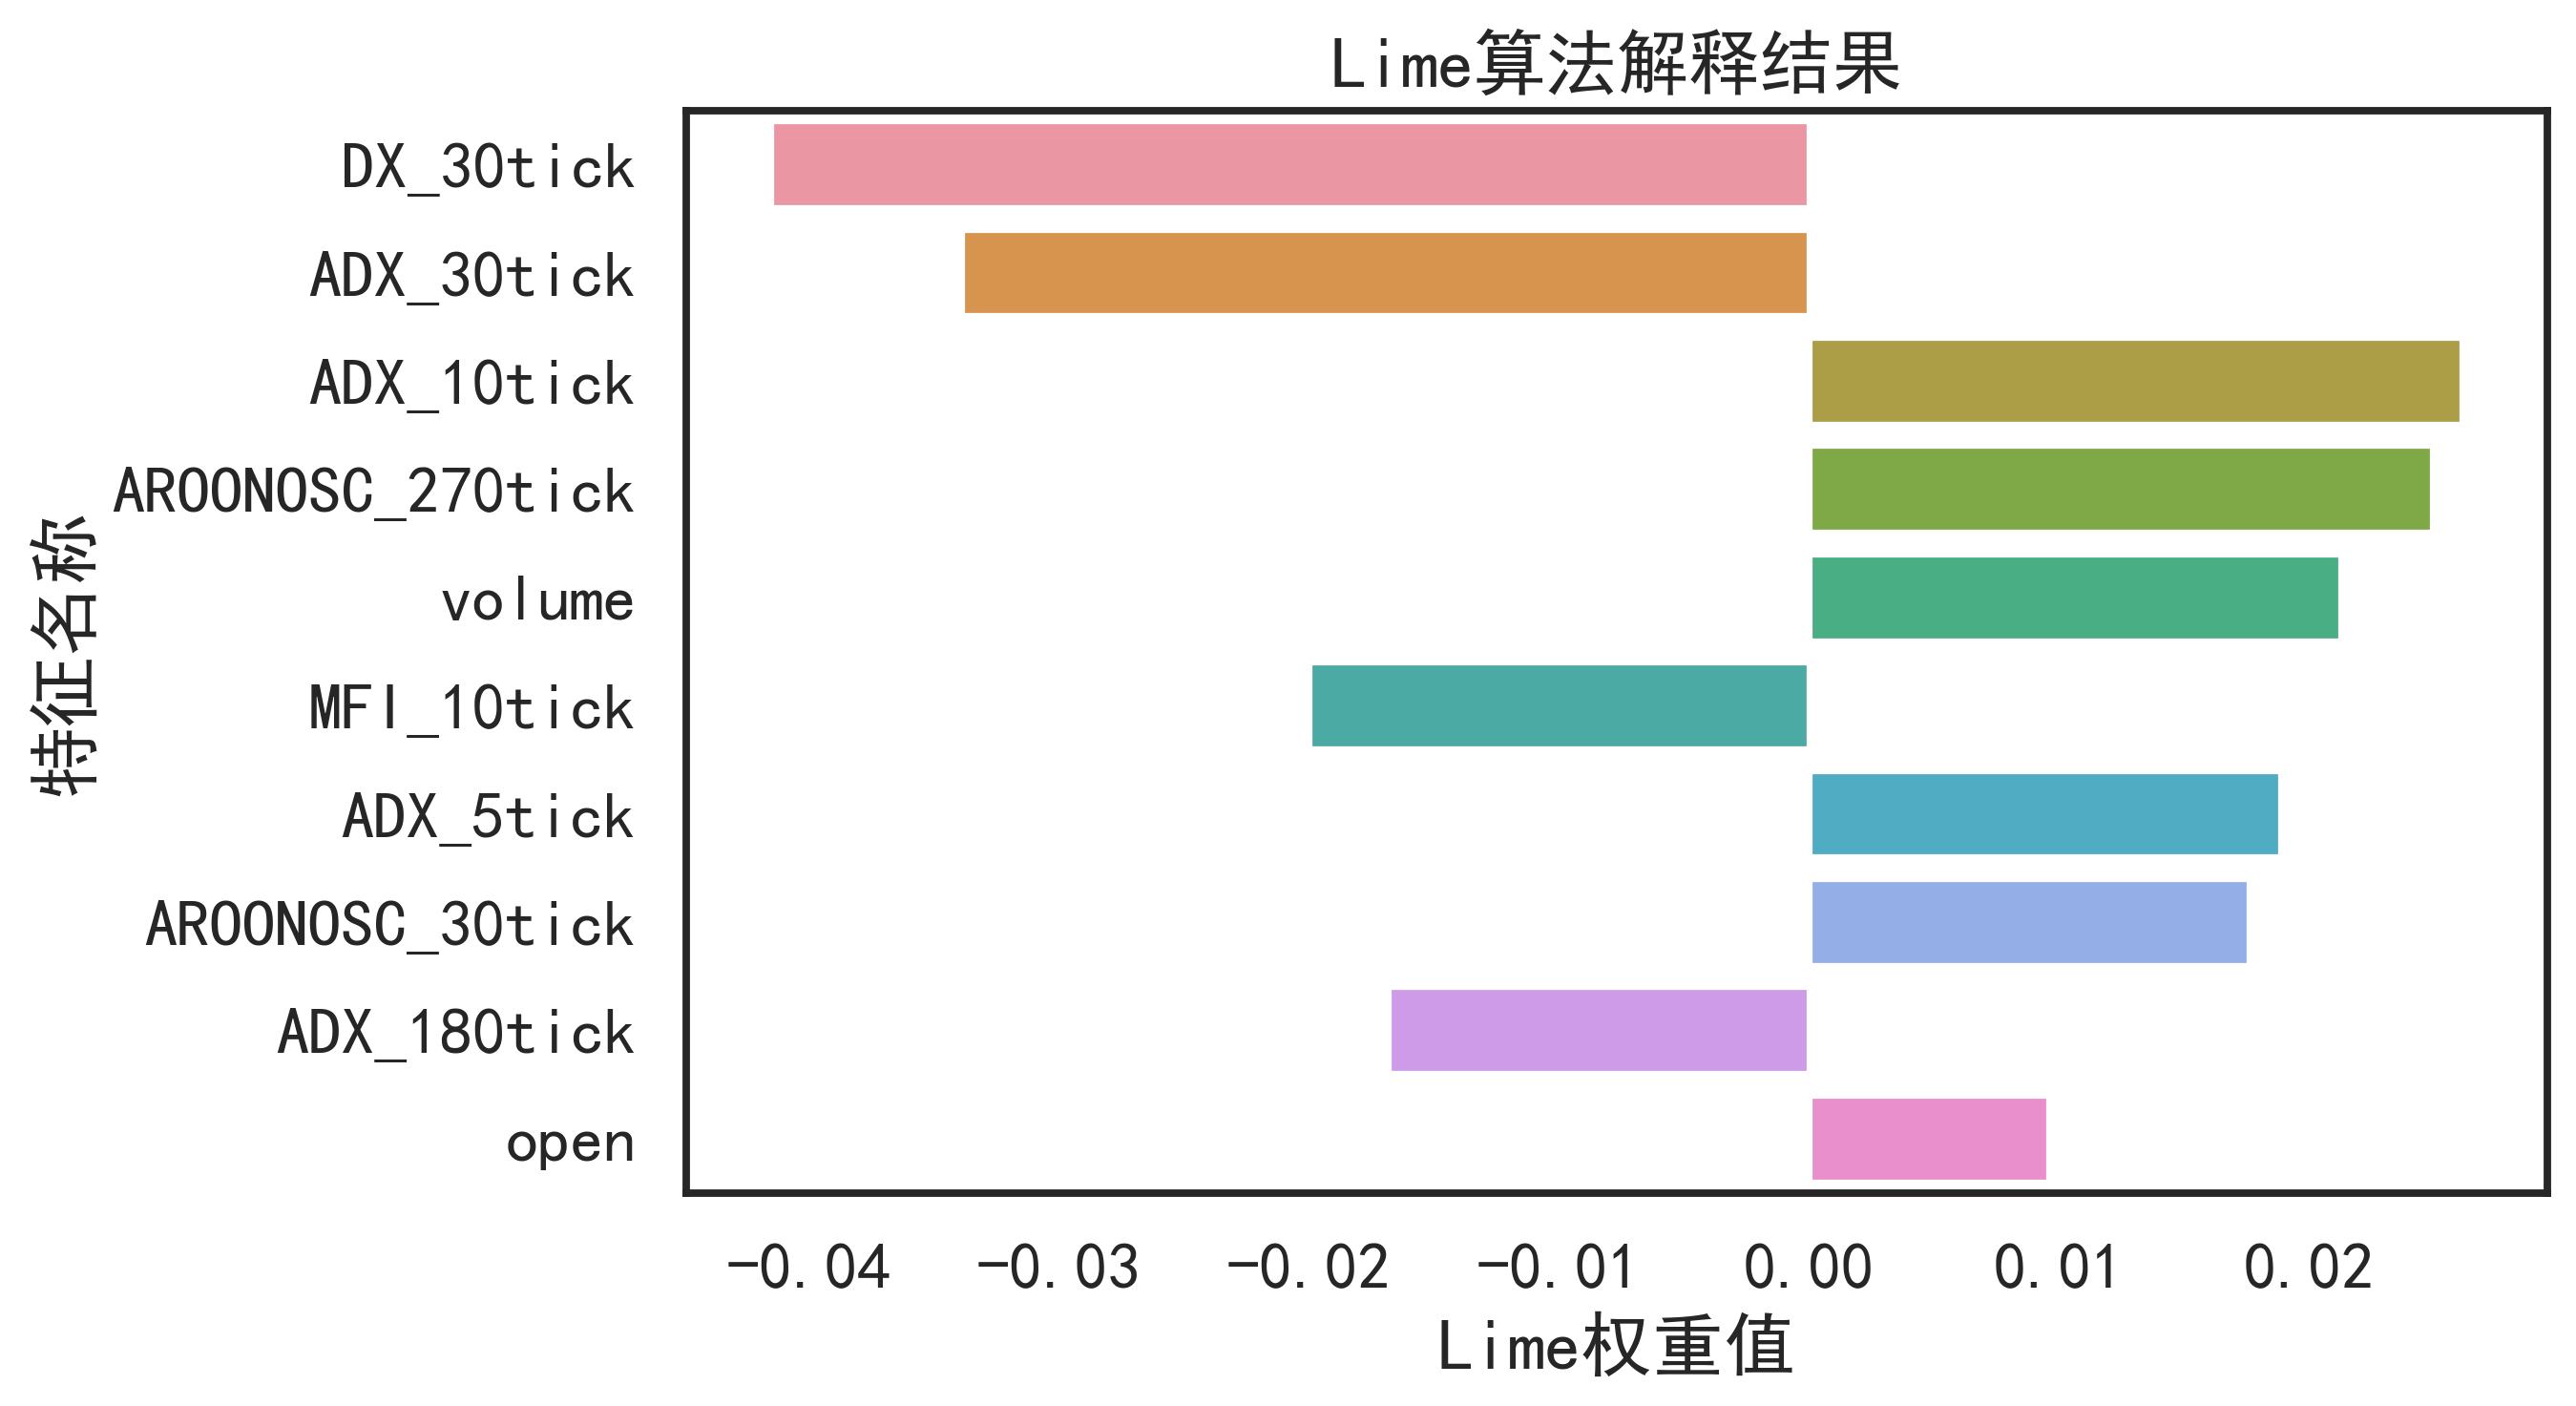

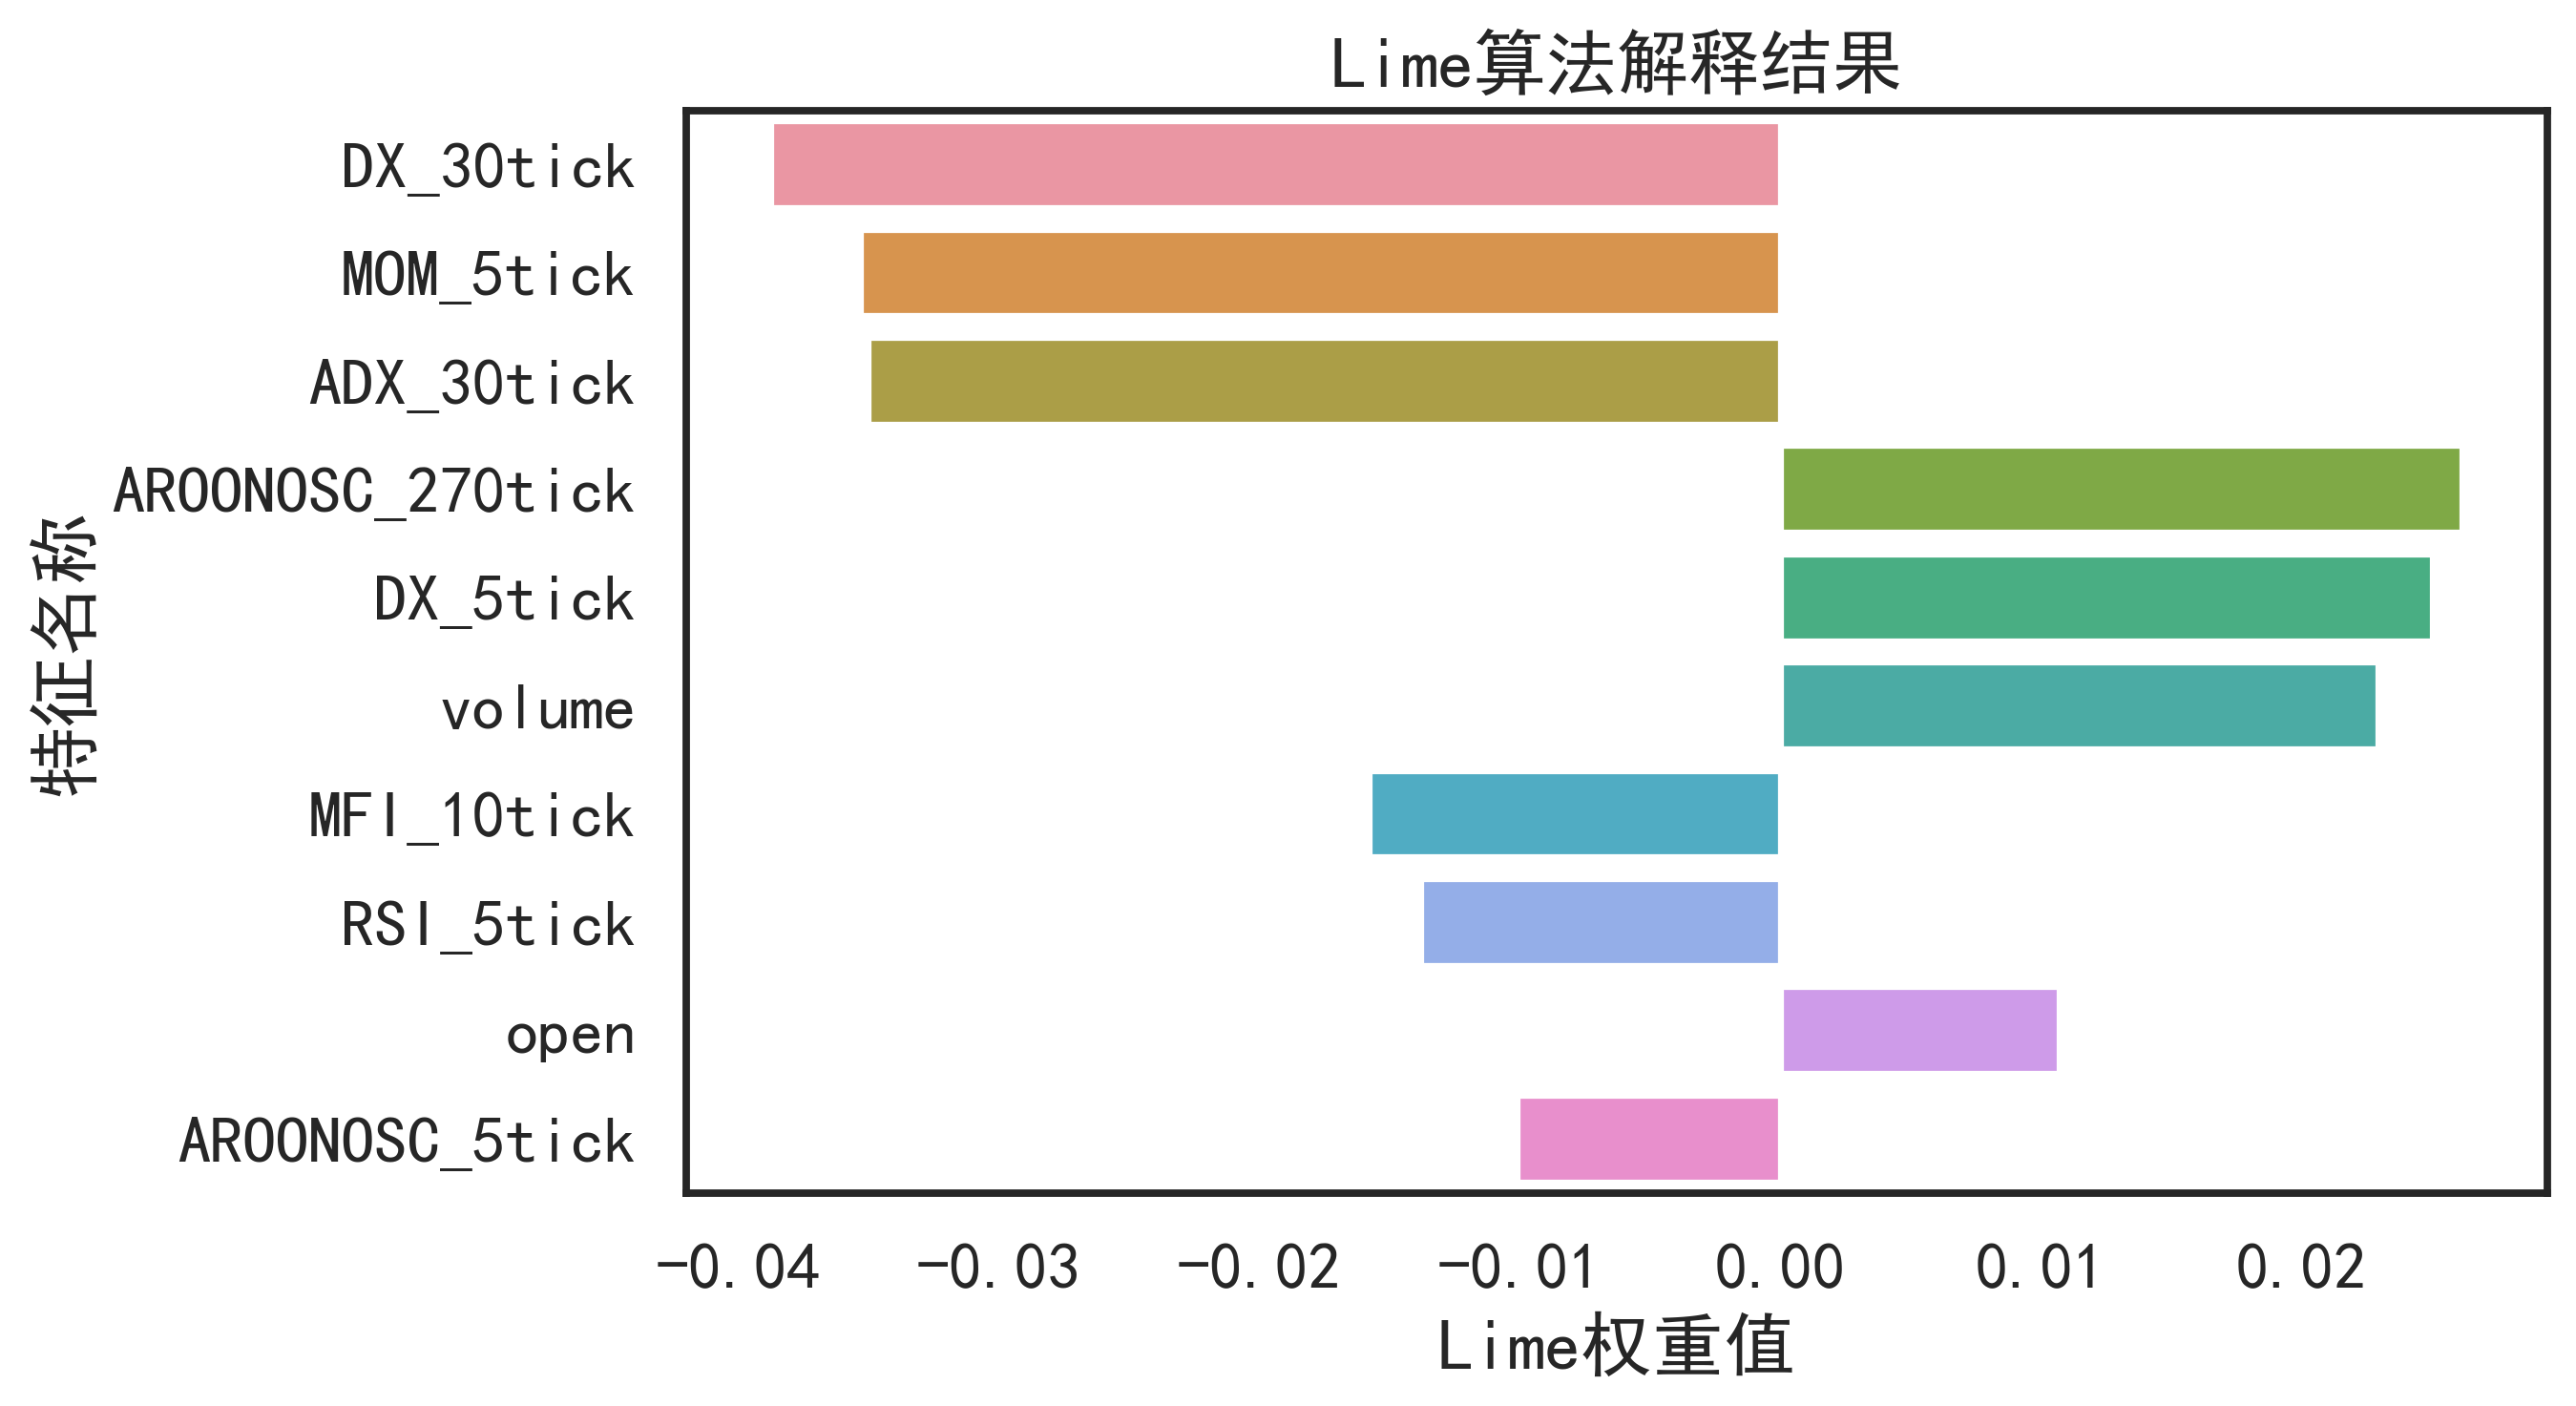

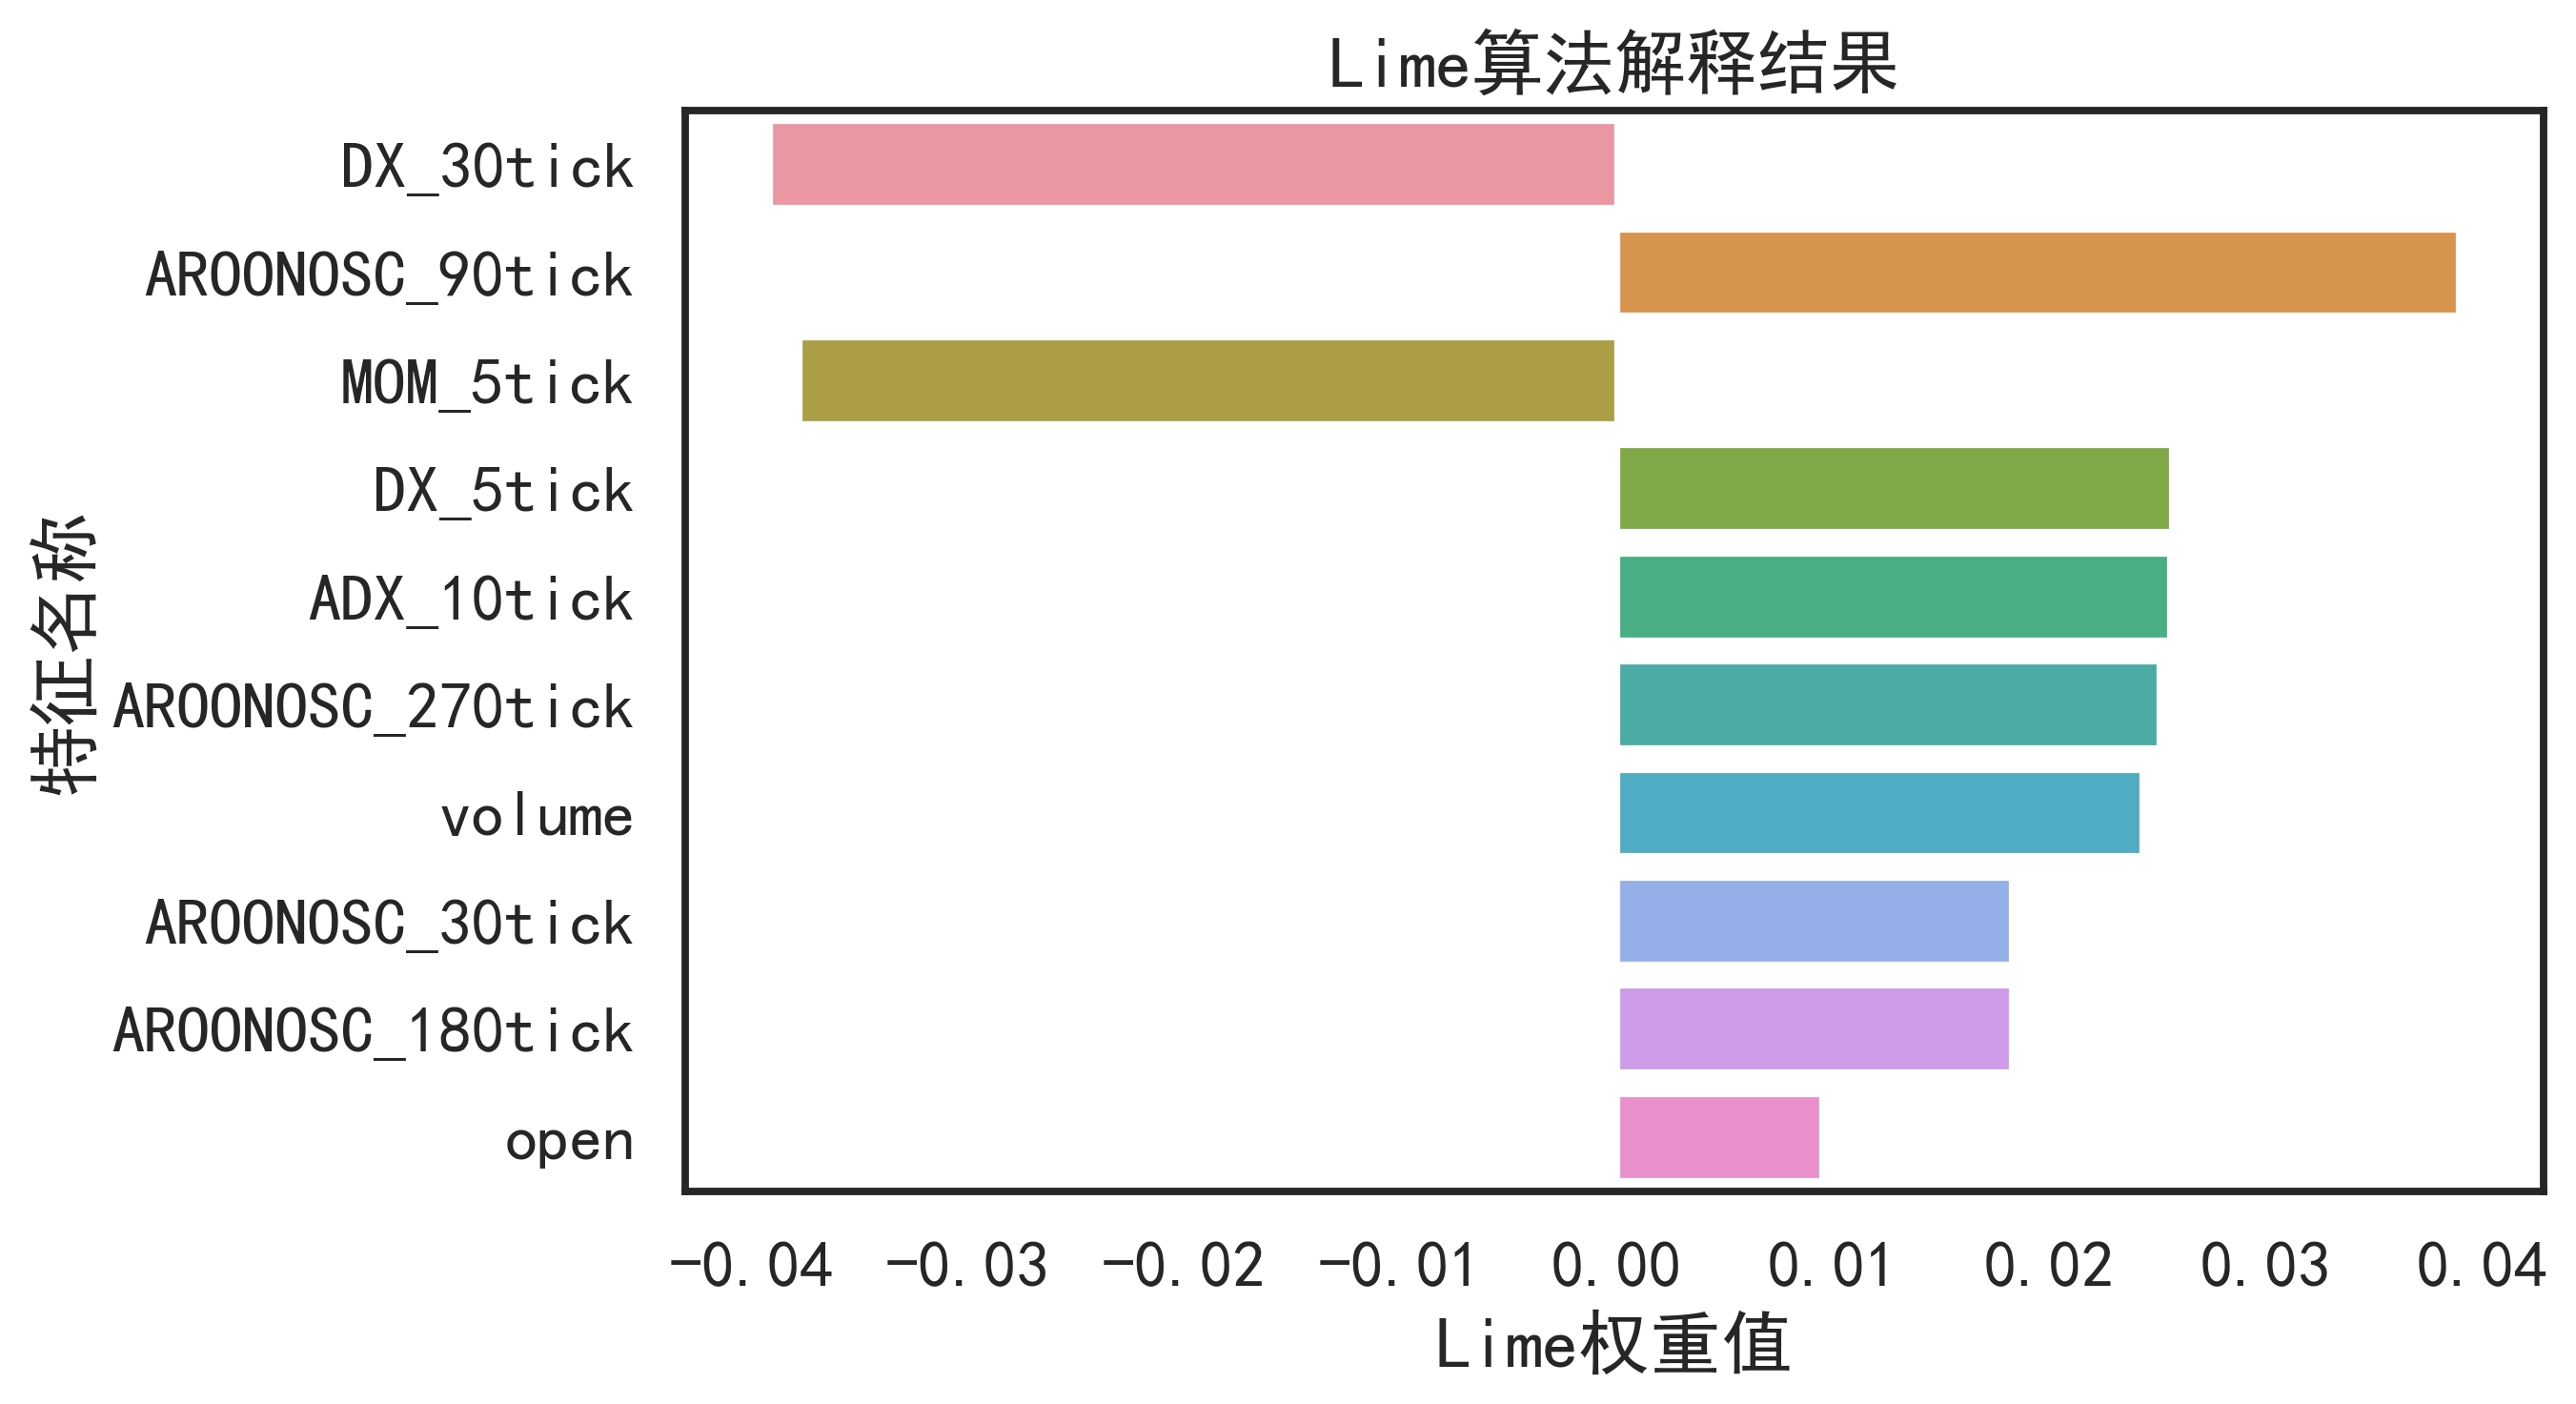

In [3]:
random_explain, max_explain, min_explain = lime_explainer.run_lime_explain()

In [5]:
random_explain.show_in_notebook()